# Diffuse large B-cell & Follicular lymphoma classification using ANOVA F-test feature selection method & SVM, Random Forest classifiers

In this notebook, we'll use a feature-selection method (ANOVA F-test) to train classifiers (SVM & RF). SMOTE has been used for over-sampling & instead of train-test split, we use Stratified K-Fold Cross Validation as a way to estimate out-of-sample performance because our dataset is pretty small.

# Importing necessary libraries

In [1]:
#For importing & manipulating the dataset
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 20)
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.feature_selection import f_classif, SelectKBest
from imblearn.over_sampling import SMOTE

#For data visualization
import matplotlib.pyplot as plt
%matplotlib inline

#For building & training models
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

#For evaluating models
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split, KFold, StratifiedShuffleSplit

#Miscellaneous
import warnings
warnings.filterwarnings('ignore')
import pickle

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# Importing the dataset & very basic analysis

In [59]:
df = pd.read_table('/content/DLBCL.tab')

In [60]:
df.head(5)

,A28102,AB000114_at,AB000115_at,AB000220_at,AB000409_at,AB000449_at,AB000450_at,AB000460_at,AB000462_at,AB000464_at,...,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at,class
0,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,...,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,DLBCL FL
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,class
2,-1,-45,176,97,-57,233,265,945,56,819,...,1036,-161,1523,-72,897,366,3,76,-28,DLBCL
3,25,-17,531,353,122,155,209,1688,42,639,...,4254,-75,6056,-68,737,81,-4,41,-45,DLBCL
4,73,91,257,80,614,507,760,2252,196,863,...,1934,-129,2901,-9,946,450,38,164,-62,DLBCL


In [61]:
df.describe()

,A28102,AB000114_at,AB000115_at,AB000220_at,AB000409_at,AB000449_at,AB000450_at,AB000460_at,AB000462_at,AB000464_at,...,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at,class
count,78,78,78,78,78,78,78,78,78,78,...,78,78,78,78,78,78,78,78,78,79
unique,74,68,76,76,77,75,72,76,69,76,...,78,75,77,73,73,75,71,74,65,4
top,124,30,184,71,157,135,87,1720,42,320,...,678,-21,311,-111,875,-206,1,73,-25,DLBCL
freq,2,2,2,2,2,2,2,2,3,2,...,1,3,2,2,2,2,3,3,3,58


In [62]:
df_types = df.iloc[0]

In [63]:
pd.value_counts(df_types)

continuous    7070
DLBCL FL         1
Name: 0, dtype: int64

All features are continuous except for the last column which is the target variable - There's 2 classes (DLBCL & FL).

In [64]:
pd.value_counts(df.iloc[1],dropna=False)

NaN      7070
class       1
Name: 1, dtype: int64

In [65]:
df.drop(index=[0,1],inplace=True)

In [66]:
df.reset_index(inplace=True,drop=True)

In [67]:
df

,A28102,AB000114_at,AB000115_at,AB000220_at,AB000409_at,AB000449_at,AB000450_at,AB000460_at,AB000462_at,AB000464_at,...,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at,class
0,-1,-45,176,97,-57,233,265,945,56,819,...,1036,-161,1523,-72,897,366,3,76,-28,DLBCL
1,25,-17,531,353,122,155,209,1688,42,639,...,4254,-75,6056,-68,737,81,-4,41,-45,DLBCL
2,73,91,257,80,614,507,760,2252,196,863,...,1934,-129,2901,-9,946,450,38,164,-62,DLBCL
3,267,41,202,138,198,355,245,1469,170,384,...,2469,93,2465,-119,339,321,-63,73,-13,DLBCL
4,16,24,187,39,145,254,571,930,-11,439,...,608,-39,1667,-87,721,213,15,155,-26,DLBCL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,205,116,361,295,424,286,239,1376,249,540,...,1014,-531,1039,-325,412,-29,-264,-292,-384,FL
73,323,123,498,303,-91,135,231,1938,273,1795,...,1629,-378,311,-251,1571,861,-53,17,-396,FL
74,83,-63,164,120,176,344,396,1348,210,684,...,573,-26,1170,-262,322,-109,-221,-213,-318,FL
75,27,-194,346,107,11,125,60,982,143,550,...,501,-329,335,-214,875,157,-97,-120,-291,FL


In [68]:
df['class'].value_counts()

DLBCL    58
FL       19
Name: class, dtype: int64

58 DLBCL & 19 FL - Therefore, imbalanced class distribution.

In [70]:
df.isnull().sum().sum()

0

In [71]:
df.loc[0][0]

'-1'

Elements are string objects.

In [72]:
df['class'][df['class']=='DLBCL'] = 0

In [73]:
df['class'][df['class']=='FL'] = 1

DLBCL is encoded as 0 & FL as 1

In [74]:
df['class']

0     0
1     0
2     0
3     0
4     0
     ..
72    1
73    1
74    1
75    1
76    1
Name: class, Length: 77, dtype: object

In [75]:
df.columns

Index(['A28102', 'AB000114_at', 'AB000115_at', 'AB000220_at', 'AB000409_at',
       'AB000449_at', 'AB000450_at', 'AB000460_at', 'AB000462_at',
       'AB000464_at',
       ...
       'U58516_at', 'U73738_at', 'X06956_at', 'X16699_at', 'X83863_at',
       'Z17240_at', 'L49218_f_at', 'M71243_f_at', 'Z78285_f_at', 'class'],
      dtype='object', length=7071)

In [78]:
df = df.apply(pd.to_numeric)

In [80]:
df.loc[0][0]

-1

In [81]:
X = df.drop(columns='class')
y = df['class']

In [83]:
X, y = shuffle(X, y, random_state=1)

In [84]:
y.reset_index(inplace=True,drop=True)
X.reset_index(inplace=True,drop=True)

In [86]:
X_df = X
y_df = y

In [87]:
X=X.to_numpy()
y=y.to_numpy()

# Cross Validation Loop

In [90]:
def cross_val(num_features,model_type,ftr_select,to_smote,minority_frac,num_trials=20):

  #arrays contain values 
  means_acc = [] #array where each element is the mean value of accuracy across all folds in a single trial
  #stddev_acc = [] #array where each element is the std. dev. of accuracy across all folds in a single trial

  #run cross validation multiple times
  for i in range(num_trials): 

    # configure the cross-validation procedure
    cv = StratifiedShuffleSplit(n_splits=10, test_size =20)
    acc_arr = [] #array where each element is the accuracy score of each fold

    for train_ix, test_ix in cv.split(X,y):
      
      # split data
      X_train, X_test = X[train_ix, :], X[test_ix, :]
      y_train, y_test = y[train_ix], y[test_ix]

      #feature selection
      if ftr_select == 'anova_f_stat':
        selector = SelectKBest(f_classif, k=num_features)
        selector.fit(X_train, y_train)
        ftr_mask = selector.get_support()
        X_train_new = (X_train.T[ftr_mask]).T
        X_test_new = (X_test.T[ftr_mask]).T
      if ftr_select == None:
        X_train_new = X_train
        X_test_new = X_test
      
      #oversampling
      if to_smote == True:
        oversample = SMOTE(sampling_strategy=minority_frac) #50% of majority class
        X_train_new, y_train = oversample.fit_resample(X_train_new, y_train)

      #scaling
      stdscaler = StandardScaler()
      stdscaler.fit(X_train_new)
      X_train_new = stdscaler.transform(X_train_new)
      X_test_new = stdscaler.transform(X_test_new)

      #model training and prediction
      if model_type == 'svm':
        model = SVC(C=1.0, kernel='rbf')
      if model_type == 'rf' :
        model = RandomForestClassifier(n_estimators=100)
      model.fit(X_train_new, y_train)
      y_pred = model.predict(X_test_new)

      #accuracy calculation of test set in a single fold
      acc_arr.append(accuracy_score(y_test, y_pred))

    means_acc.append(np.mean(acc_arr))
    #stddev_acc.append(np.std(acc_arr))
  
  return means_acc

# Optimizing no. of features to be used in feature selection process

First, performance without feature selection

In [ ]:
means_acc = cross_val(num_features = None,
                      model_type = 'svm',
                      ftr_select = None,
                      to_smote=False,
                      minority_frac=None)

In [ ]:
print('mean acc. across all trials :',np.round(np.mean(means_acc),4))

mean acc. across all trials : 0.7717


Now, we use feature subsets of various sizes.

In [ ]:
num_features_arr = list([10,50,100,150,200,250,300,350,400,450,500,1000,2000,3000,4000,5000,6000,7000,7070])

In [ ]:
acc_svm = [] 
for num in num_features_arr:
  means_acc = cross_val(num_features = num,
                        model_type = 'svm',
                        ftr_select = 'anova_f_stat',
                        to_smote=False,
                        minority_frac=None)
  
  acc_svm.append(np.mean(means_acc))

In [ ]:
print('mean acc. across all trials |','num',num_features_arr[np.argmax(acc_svm)],'| value',np.round(np.max(acc_svm),4))

mean acc. across all trials | num 500 | value 0.9382


In [ ]:
acc_rf = [] 
for num in num_features_arr:
  means_acc = cross_val(num_features = num,
                        model_type = 'rf',
                        ftr_select = 'anova_f_stat',
                        to_smote=False,
                        minority_frac=None)
  
  acc_rf.append(np.mean(means_acc))

In [ ]:
print('mean acc. across all trials |','num',num_features_arr[np.argmax(acc_rf)],'| value',np.round(np.max(acc_rf),4))

mean acc. across all trials | num 200 | value 0.8962


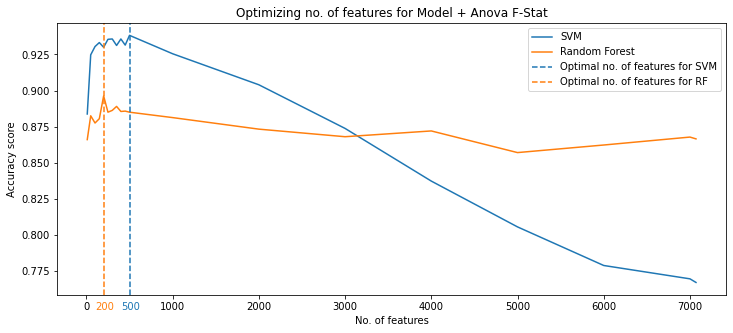

In [ ]:
plt.figure(figsize=(12,5))
plt.title('Optimizing no. of features for Model + Anova F-Stat')

plt.plot(num_features_arr,acc_svm,label='SVM',color='C0')
plt.plot(num_features_arr,acc_rf,label='Random Forest',color='C1')

plt.axvline(num_features_arr[np.argmax(acc_svm)],color='C0',linestyle='--',label='Optimal no. of features for SVM')
plt.text(num_features_arr[np.argmax(acc_svm)]-100,0.748,num_features_arr[np.argmax(acc_svm)],color='C0')

plt.axvline(num_features_arr[np.argmax(acc_rf)],color='C1',linestyle='--',label='Optimal no. of features for RF')
plt.text(num_features_arr[np.argmax(acc_rf)]-100,0.748,num_features_arr[np.argmax(acc_rf)],color='C1')

plt.legend()
plt.xlabel('No. of features')
plt.ylabel('Accuracy score')
plt.show()

These above scores also are an estimate for the model performance without oversampling (SMOTE)

In [91]:
num_ftrs_svm = 500
num_ftrs_rf = 200

# Optimizing percentage for SMOTE

In [ ]:
minority_frac_arr = [0.4,0.5,0.6,0.7,0.8,0.9,1.0]

In [ ]:
pd.Series(y).value_counts()

0    58
1    19
dtype: int64

In [ ]:
58*0.4

23.200000000000003

In [ ]:
58*0.3

17.4

Lesser than what is available in class 1. Let's start with 0.4

In [ ]:
acc_svm_smote = [] 
for minority_frac in minority_frac_arr:
  means_acc = cross_val(num_features = num_ftrs_svm,
                        model_type = 'svm',
                        ftr_select = 'anova_f_stat',
                        to_smote=True,
                        minority_frac=minority_frac)
  
  acc_svm_smote.append(np.mean(means_acc))

In [ ]:
print('mean acc. across all trials |','num',minority_frac_arr[np.argmax(acc_svm_smote)],'| value',np.round(np.max(acc_svm_smote),4))

mean acc. across all trials | num 1.0 | value 0.9392


In [ ]:
acc_rf_smote = [] 
for minority_frac in minority_frac_arr:
  means_acc = cross_val(num_features = num_ftrs_rf,
                        model_type = 'rf',
                        ftr_select = 'anova_f_stat',
                        to_smote=True,
                        minority_frac=minority_frac)
  
  acc_rf_smote.append(np.mean(means_acc))

In [ ]:
print('mean acc. across all trials |','num',minority_frac_arr[np.argmax(acc_rf_smote)],'| value',np.round(np.max(acc_rf_smote),4))

mean acc. across all trials | num 1.0 | value 0.9278


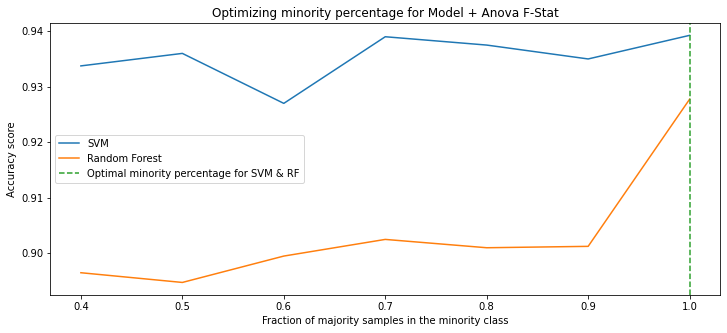

In [ ]:
plt.figure(figsize=(12,5))
plt.title('Optimizing minority percentage for Model + Anova F-Stat')

plt.plot(minority_frac_arr,acc_svm_smote,label='SVM',color='C0')
plt.plot(minority_frac_arr,acc_rf_smote,label='Random Forest',color='C1')

plt.axvline(minority_frac_arr[np.argmax(acc_svm_smote)],color='C2',linestyle='--',label='Optimal minority percentage for SVM & RF')

plt.legend()
plt.xlabel('Fraction of majority samples in the minority class')
plt.ylabel('Accuracy score')
plt.show()

In [92]:
minority_frac_svm = 1.0
minority_frac_rf = 1.0

# Training final models

In [28]:
def train_final_model(model_type, num_ftrs, minority_frac): 

  #feature selection
  selector = SelectKBest(f_classif, k=num_ftrs)
  selector.fit(X, y)
  ftr_mask = selector.get_support()
  X_new = (X.T[ftr_mask]).T

  #oversampling
  oversample = SMOTE(sampling_strategy=minority_frac) 
  X_new, y_new = oversample.fit_resample(X_new, y)

  #scaling
  stdscaler = StandardScaler()
  stdscaler.fit(X_new)
  X_new = stdscaler.transform(X_new)

  #model training
  if model_type == 'svm':
    model = SVC(C=1.0, kernel='rbf')
  if model_type == 'rf' :
    model = RandomForestClassifier(n_estimators=100)
  model.fit(X_new, y_new)

  #model prediction
  y_pred = model.predict(X_new)

  print('Training Score :')
  print('acc. :',accuracy_score(y_new, y_pred))

  return model, selector, stdscaler

## SVM

In [ ]:
svm_dict = {}

In [ ]:
svm, svm_selector, svm_stdscaler = train_final_model(model_type='svm',num_ftrs=num_ftrs_svm,minority_frac=minority_frac_svm)

Training Score :
acc. : 1.0


In [ ]:
ftrs_arr_svm = np.array(X_df.columns)[svm_selector.get_support()]

In [ ]:
svm_dict['model'] = svm
svm_dict['selector'] = svm_selector
svm_dict['scaler'] = svm_stdscaler
svm_dict['num_features'] = num_ftrs_svm
svm_dict['minority_frac'] = minority_frac_svm
svm_dict['features_list'] = ftrs_arr_svm

## Random Forest

In [ ]:
rf_dict = {}

In [ ]:
rf, rf_selector, rf_stdscaler = train_final_model(model_type='rf',num_ftrs=num_ftrs_rf,minority_frac=minority_frac_rf)

Training Score :
acc. : 1.0


In [ ]:
ftrs_arr_rf = np.array(X_df.columns)[rf_selector.get_support()]

In [ ]:
rf_dict['model'] = rf
rf_dict['selector'] = rf_selector
rf_dict['scaler'] = rf_stdscaler
rf_dict['num_features'] = num_ftrs_rf
rf_dict['minority_frac'] = minority_frac_rf
rf_dict['features_list'] = ftrs_arr_rf

# Prediction

In [129]:
def prediction(model, input_X, selector, stdscaler): 

  #apply feature mask
  ftr_mask = selector.get_support()
  input_X = (input_X.T[ftr_mask]).T

  #scaling
  input_X = stdscaler.transform(input_X)

  #model prediction
  y_pred = model.predict(input_X)

  return y_pred

In [135]:
X_input = X

In [136]:
y_pred = prediction(svm_dict['model'], X_input, svm_dict['selector'], svm_dict['scaler'])

In [ ]:
y_pred = prediction(rf_dict['model'], X_input, rf_dict['selector'], rf_dict['scaler'])

# Saving final models for later use

In [ ]:
filename = '/content/svm_dict.pkl'
pickle.dump(svm_dict, open(filename, 'wb'))

In [ ]:
filename = '/content/rf_dict.pkl'
pickle.dump(rf_dict, open(filename, 'wb'))

# Loading models

In [145]:
filename = '/content/svm_dict.pkl'
dict_svm = pickle.load(open(filename, 'rb'))

y_pred = prediction(dict_svm['model'], X_input, dict_svm['selector'], dict_svm['scaler'])
print('Acc. : ',accuracy_score(y, y_pred))

Acc. :  1.0


In [146]:
filename = '/content/rf_dict.pkl'
dict_rf = pickle.load(open(filename, 'rb'))

y_pred = prediction(dict_rf['model'], X_input, dict_rf['selector'], dict_rf['scaler'])
print('Acc. : ',accuracy_score(y, y_pred))

Acc. :  1.0


# Visualization

## Importance of features

SVM uses 500 features where RF uses 200 features. The top 200 features in both will be common for ANOVA f-test feature selection method, b'cuz although we optimized the "no." of features to be used by training the models; which features will be selected completely relies on the ANOVA f-test method. Hence, the common features.

In [254]:
ftrs_scores = np.sort(dict_svm['selector'].scores_)[::-1][:500]

In [255]:
ftrs_mask = np.argsort(dict_svm['selector'].scores_)[::-1][:500]

In [256]:
ftrs_names = np.array(X_df.columns)[ftrs_mask]

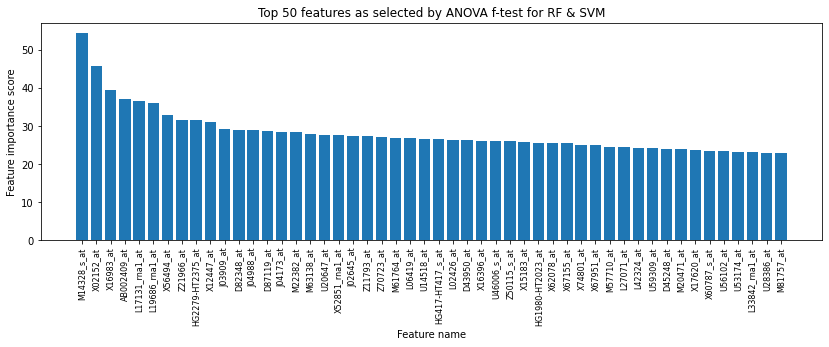

In [258]:
plt.figure(figsize=(14,4))
plt.bar(x=ftrs_names[:50],height=ftrs_scores[:50])
plt.xticks(rotation=90, fontsize=8)
plt.xlabel('Feature name')
plt.ylabel('Feature importance score')
plt.title('Top 50 features as selected by ANOVA f-test for RF & SVM')
plt.show()

To make plotting feature importance scores of 500 features more manageable, we sort the features in decreasing order of importance and create groups of 10 features each. To summarize the feature importance score of each of these groups, we plot the mean & std. dev. of each of these groups (total 50) rather than that of the individual features (total 500).

In [262]:
means_50 = []
stddev_50 = []
x_labels_50 = []
for num in range(0,500,10):
  means_50.append(np.mean(ftrs_scores[num:num+10]))
  stddev_50.append(np.std(ftrs_scores[num:num+10]))
  x_labels_50.append(f'{num}-{num+10}')

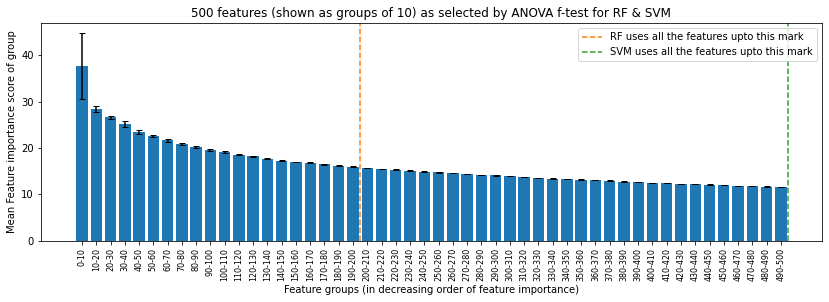

In [292]:
plt.figure(figsize=(14,4))
plt.bar(x_labels_50,means_50, yerr = stddev_50, capsize=3)
plt.xticks(rotation=90, fontsize=8)
plt.xlabel('Feature groups (in decreasing order of feature importance)')
plt.ylabel('Mean Feature importance score of group')
plt.axvline(19.5,color='C1',linestyle='dashed',label='RF uses all the features upto this mark')
plt.axvline(49.5,color='C2',linestyle='dashed',label='SVM uses all the features upto this mark')
plt.title('500 features (shown as groups of 10) as selected by ANOVA f-test for RF & SVM')
plt.legend()
plt.show()

## Distribution of accuracy scores across various trials (done only for SVM)

In [139]:
means_acc_20 =  cross_val(num_features = num_ftrs_svm,
                          model_type = 'svm',
                          ftr_select = 'anova_f_stat',
                          to_smote=True,
                          minority_frac=minority_frac_svm,num_trials=20)

In [ ]:
mu = np.mean(means_acc_20)
sigma = np.std(means_acc_20)
print('Mean:',mu)
print('Std. Dev.:',sigma)

Mean: 0.9422499999999999
Std. Dev.: 0.014532291629333604


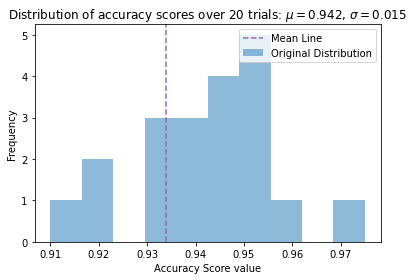

In [ ]:
fig, ax = plt.subplots()

# the histogram of the data
ax.hist(means_acc_20,alpha=0.5,label='Original Distribution')

# fitting a normal distribution
# bins = np.linspace(np.min(means_acc_20),np.max(means_acc_20),50)
# y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
#      np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
# ax.plot(bins, y, '--',color='C1',label='Fitted Gaussian')

#mean line
ax.axvline(mu,linestyle='--',color='C4',label='Mean Line')

ax.set_xlabel('Accuracy Score value')
ax.set_ylabel('Frequency')
ax.set_title(r'Distribution of accuracy scores over 20 trials: $\mu=0.942$, $\sigma=0.015$')

fig.tight_layout()
plt.legend()
plt.show()

In [ ]:
means_acc_200 = cross_val(num_features = num_ftrs_svm,
                      model_type = 'svm',
                      ftr_select = 'anova_f_stat',
                      to_smote=True,
                      minority_frac=minority_frac_svm,num_trials=200)

In [ ]:
mu = np.mean(means_acc_200)
sigma = np.std(means_acc_200)
print('Mean:',mu)
print('Std. Dev.:',sigma)

Mean: 0.93395
Std. Dev.: 0.01699698502676282


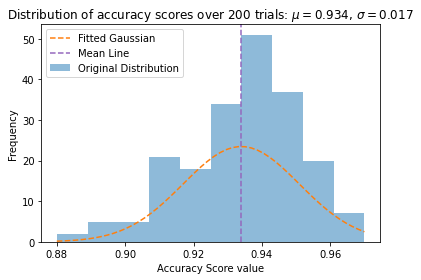

In [ ]:
fig, ax = plt.subplots()

# the histogram of the data
ax.hist(means_acc_200,alpha=0.5,label='Original Distribution')

# fitting a normal distribution
bins = np.linspace(np.min(means_acc_200),np.max(means_acc_200),50)
y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
     np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
ax.plot(bins, y, '--',color='C1',label='Fitted Gaussian')

#mean line
ax.axvline(mu,linestyle='--',color='C4',label='Mean Line')

ax.set_xlabel('Accuracy Score value')
ax.set_ylabel('Frequency')
ax.set_title(r'Distribution of accuracy scores over 200 trials: $\mu=0.934$, $\sigma=0.017$')

fig.tight_layout()
plt.legend()
plt.show()